In [1]:
pip install pylibjpeg

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gdcm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 13.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 7.2 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.0 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --force-reinstall pillow


Defaulting to user installation because normal site-packages is not writeable
  Using cached Pillow-10.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (3.6 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 10.1.0
    Uninstalling Pillow-10.1.0:
      Successfully uninstalled Pillow-10.1.0
ERROR: Could not install packages due to an OSError: [Errno 16] Device or resource busy: '.nfs00000000000080ab00000327'

Note: you may need to restart the kernel to use updated packages.


# Converting a List of DICOMs to PNG. This notebook will read DICOM files and convert them to 16-bit PNG. Flipping logic is included such that both left and right breast images will be pointed in the same direction to improve model training.

In [5]:
pip install pydicom

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install pypng

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 1.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pydicom
import numpy as np
import pandas as pd
import png

In [2]:
import gc
import glob
import os
import random

# import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from joblib import Parallel, delayed
from matplotlib import animation, rc
from scipy.ndimage import zoom
from tqdm.notebook import tqdm

In [9]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 7.0 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Get DICOM image metadata
class DCM_Tags():
    def __init__(self, img_dcm):
        try:
            self.laterality = img_dcm.ImageLaterality
        except AttributeError:
            self.laterality = np.nan

        try:
            self.view = img_dcm.ViewPosition
        except AttributeError:
            self.view = np.nan

        try:
            self.orientation = img_dcm.PatientOrientation
        except AttributeError:
            self.orientation = np.nan

# Check whether DICOM should be flipped
def check_dcm(imgdcm):
    # Get DICOM metadata
    tags = DCM_Tags(imgdcm)
    print("tags.views: ",tags.view)

    # If image orientation tag is defined
    if ~pd.isnull(tags.orientation):
        # CC view
        if tags.view == 'CC':
            if tags.orientation[0] == 'P':
                flipHorz = True
            else:
                flipHorz = False

            if (tags.laterality == 'L') & (tags.orientation[1] == 'L'):
                flipVert = True
            elif (tags.laterality == 'R') & (tags.orientation[1] == 'R'):
                flipVert = True
            else:
                flipVert = False

        # MLO or ML views
        elif (tags.view == 'MLO') | (tags.view == 'ML'):
            if tags.orientation[0] == 'P':
                flipHorz = True
            else:
                flipHorz = False

            if (tags.laterality == 'L') & ((tags.orientation[1] == 'H') | (tags.orientation[1] == 'HL')):
                flipVert = True
            elif (tags.laterality == 'R') & ((tags.orientation[1] == 'H') | (tags.orientation[1] == 'HR')):
                flipVert = True
            else:
                flipVert = False

        # Unrecognized view
        else:
            flipHorz = False
            flipVert = False

    # If image orientation tag is undefined
    else:
        # Flip RCC, RML, and RMLO images
        if (tags.laterality == 'R') & ((tags.view == 'CC') | (tags.view == 'ML') | (tags.view == 'MLO')):
            flipHorz = True
            flipVert = False
        else:
            flipHorz = False
            flipVert = False

    return flipHorz, flipVert

# Save DICOM pixel array as PNG
def save_dcm_image_as_png(image, png_filename, bitdepth=12):
    with open(png_filename, 'wb') as f:
        writer = png.Writer(height=image.shape[0],
                            width=image.shape[1],
                            bitdepth=bitdepth,
                            greyscale=True)
        writer.write(f, image.tolist())

In [4]:
# Convert list of DICOMs to PNGs
def process_dcm_list(dcm_list, save_path):
    for i, dcm_path in enumerate(dcm_list):
        print(f"Processing DICOM #{i}...")

        # Load DICOM
        dcm = pydicom.dcmread(dcm_path)
        img = dcm.pixel_array

        # Check if a horizontal flip is necessary
        horz, _ = check_dcm(dcm)
        if horz:
            # Flip img horizontally
            img = np.fliplr(img)

        # Get new file name
        split_fn = dcm_path[:-4].split('/')
        new_fn = f"{split_fn[-1]}_conv.png"

        # Save PNG
        png_path = save_path + new_fn
        save_dcm_image_as_png(img, png_path)

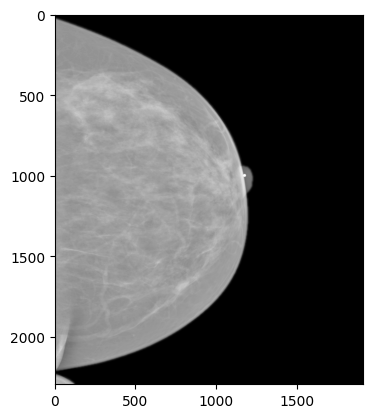

In [3]:
import pydicom
import matplotlib.pyplot as plt
dicom = pydicom.read_file('/local/scratch/shared-directories/ssanet/SCRIPTS/Test_DCM/1.2.826.0.1.3680043.8.498.11459615656252960969245575433082445423.dcm')
image = dicom.pixel_array

plt.imshow(image, 'grey')
plt.savefig

In [18]:
# Provide a list of DICOM paths and a target directory
df_one_patient = pd.read_csv('/local/scratch/shared-directories/ssanet/SCRIPTS/one patient.csv')

paths_list = df_one_patient['path'].values[0].strip("[]").replace("'", "").split(", ")

def update_paths(paths, new_base):
    updated_paths = []
    for path in paths:
        index_of_cohort = path.find('cohort_1')
        updated_path = new_base + path[index_of_cohort:]
        updated_paths.append(updated_path)
    return updated_paths

new_base_path = '/local/scratch/shared-directories/ssanet/EMBED/'
dcm_list = update_paths(paths_list, new_base_path)

# dcm_list = ['/local/scratch/shared-directories/ssanet/Dataset_EMBED/images/cohort_1/10000879/1.2.842.113970.3.62.1.56868341.20180426.1095160/1.2.840.113684.2750825173.1524118967.4848.25046.1/1.2.826.0.1.3680043.8.498.12326784267688742524174894068105129442.dcm']

save_path = "/local/scratch/shared-directories/ssanet/SCRIPTS/"

# # Convert DICOMs
process_dcm_list(dcm_list, save_path)

Processing DICOM #0...
tags.views:  MLO
Processing DICOM #1...
tags.views:  MLO
Processing DICOM #2...
tags.views:  CC
Processing DICOM #3...
tags.views:  MLO
Processing DICOM #4...
tags.views:  CC
Processing DICOM #5...
tags.views:  CC
Processing DICOM #6...
tags.views:  MLO
Processing DICOM #7...
tags.views:  CC
Processing DICOM #8...
tags.views:  XCCL
Processing DICOM #9...
tags.views:  XCCL


In [30]:
# Provide a list of DICOM paths and a target directory
df_one_patient = pd.read_csv('/local/scratch/shared-directories/ssanet/SCRIPTS/one patient.csv')
def update_paths(paths, new_base):
    updated_paths = []
    for path in paths:
        index_of_cohort = path.find('cohort_1')
        updated_path = new_base + path[index_of_cohort:]
        updated_paths.append(updated_path)
    return updated_paths

df_one_patient['update_local_path']=None

for i in range(len(df_one_patient)):
    paths_list = df_one_patient.loc[i,'anon_dicom_path'].strip("[]").replace("'", "").split(", ")
    new_base_path = '/local/scratch/shared-directories/ssanet/EMBED/'
    dcm_list = update_paths(paths_list, new_base_path)
    df_one_patient.at[i,'update_local_path'] = dcm_list
    # print(dcm_list)

df_one_patient


,empi_anon,asses,anon_dicom_path,update_local_path
0,10000879,N,[['/mnt/NAS2/mammo/anon_dicom/cohort_1/1000087...,[/local/scratch/shared-directories/ssanet/EMBE...
1,10000879,B,[['/mnt/NAS2/mammo/anon_dicom/cohort_1/1000087...,[/local/scratch/shared-directories/ssanet/EMBE...
2,10000879,A,[['/mnt/NAS2/mammo/anon_dicom/cohort_1/1000087...,[/local/scratch/shared-directories/ssanet/EMBE...
3,10000879,M,[['/mnt/NAS2/mammo/anon_dicom/cohort_1/1000087...,[/local/scratch/shared-directories/ssanet/EMBE...
4,10000879,N,[['/mnt/NAS2/mammo/anon_dicom/cohort_1/1000087...,[/local/scratch/shared-directories/ssanet/EMBE...
5,10000879,N,[['/mnt/NAS2/mammo/anon_dicom/cohort_1/1000087...,[/local/scratch/shared-directories/ssanet/EMBE...


In [ ]:
import pandas as pd

: 